In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

VARIABLES DE ENTRADA Y SALIDA DIFUSAS

In [3]:
tmax = ctrl.Antecedent(np.arange(-5, 46, 1), 'tmax')
tmin = ctrl.Antecedent(np.arange(-10, 36, 1), 'tmin')
prob = ctrl.Antecedent(np.arange(0, 101, 1), 'prob_lluvia')
uv = ctrl.Antecedent(np.arange(0, 13, 1), 'UV')
recom_exterior = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'recom_exterior')

FUNCIONES DE MEMBRESÍA

In [5]:
# tmax
tmax['frio'] = fuzz.trapmf(tmax.universe, [-5, -5, 5, 12])
tmax['moderado'] = fuzz.trimf(tmax.universe, [10, 20, 28])
tmax['calido'] = fuzz.trapmf(tmax.universe, [25, 30, 45, 45])

# tmin
tmin['muy_frio'] = fuzz.trapmf(tmin.universe, [-10, -10, 0, 5])
tmin['frio'] = fuzz.trimf(tmin.universe, [3, 8, 13])
tmin['suave'] = fuzz.trapmf(tmin.universe, [10, 15, 35, 35])

# prob_lluvia
prob['baja'] = fuzz.trapmf(prob.universe, [0, 0, 20, 30])
prob['media'] = fuzz.trimf(prob.universe, [20, 50, 80])
prob['alta'] = fuzz.trapmf(prob.universe, [70, 85, 100, 100])

# UV
uv['bajo'] = fuzz.trapmf(uv.universe, [0, 0, 3, 6])
uv['moderado'] = fuzz.trimf(uv.universe, [4, 7, 9])
uv['alto'] = fuzz.trapmf(uv.universe, [6, 10, 14, 14])

# recom_exterior
recom_exterior['no'] = fuzz.trapmf(recom_exterior.universe, [0, 0, 0.2, 0.4])
recom_exterior['posible'] = fuzz.trimf(recom_exterior.universe, [0.3, 0.5, 0.7])
recom_exterior['si'] = fuzz.trapmf(recom_exterior.universe, [0.6, 0.8, 1, 1])

In [6]:
import matplotlib.pyplot as plt
def guardar_grafico(variable, nombre_archivo):
    plt.figure(figsize=(8, 5))
    for etiqueta in variable.terms:
        plt.plot(variable.universe, variable[etiqueta].mf, label=etiqueta)
    plt.title(nombre_archivo)
    plt.xlabel(variable.label)
    plt.ylabel("Grado de pertenencia")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{nombre_archivo}.png", dpi=300)
    plt.close()

# Generar y guardar gráficos
guardar_grafico(tmax, "tmax")
guardar_grafico(tmin, "tmin")
guardar_grafico(prob, "prob_lluvia")
guardar_grafico(uv, "UV")
guardar_grafico(recom_exterior, "recom_exterior")

REGLAS DIFUSAS

In [8]:
rules = [
    # NO RECOMENDABLE
    ctrl.Rule(prob['alta'], recom_exterior['no']),
    ctrl.Rule(tmax['frio'] & tmin['muy_frio'], recom_exterior['no']),
    ctrl.Rule(tmax['calido'] & uv['alto'], recom_exterior['no']),

    # POSIBLE
    ctrl.Rule(prob['media'] & (tmax['moderado'] | tmax['calido']), recom_exterior['posible']),
    ctrl.Rule(prob['baja'] & tmax['frio'] & tmin['frio'], recom_exterior['posible']),
    ctrl.Rule(prob['baja'] & uv['moderado'], recom_exterior['posible']),

    # SI RECOMENDABLE
    ctrl.Rule(prob['baja'] & tmax['moderado'] & tmin['suave'], recom_exterior['si']),
    ctrl.Rule(prob['baja'] & uv['bajo'], recom_exterior['si']),
    ctrl.Rule(prob['baja'] & tmax['calido'] & uv['bajo'], recom_exterior['si']),
]

SISTEMA DIFUSO

In [10]:
sistema_ctrl = ctrl.ControlSystem(rules)

FUNCIÓN PARA CALCULAR EL SCORE EXTERIOR

In [12]:
def recomendar(clima):
    sim = ctrl.ControlSystemSimulation(sistema_ctrl)
    sim.input['tmax'] = clima.get('tmax', 20)
    sim.input['tmin'] = clima.get('tmin', 10)
    sim.input['prob_lluvia'] = clima.get('lluvia', 0)
    sim.input['UV'] = clima.get('UV', 5)
    sim.compute()
    return sim.output.get('recom_exterior')

FUNCIÓN DE FILTRO

In [14]:
# Set de lugares de exterior
LUGARES_EXTERIOR = {"castillo_aliaga", "parque_natural", "mirador_sierra"}

def filtrar_por_clima(recomendaciones, clima):
    """
    Filtra recomendaciones de lugares de exterior si el clima no es favorable.
    recomendaciones: dict {lugar: 1/0} (salida del primer modelo)
    clima: dict con tmax, tmin, lluvia, estado_cielo, UV
    """
    score_exterior = recomendar(clima)
    filtradas = recomendaciones.copy()

    if score_exterior < 0.50:  # umbral configurable
        for lugar in LUGARES_EXTERIOR:
            if lugar in filtradas:
                filtradas[lugar] = 0
    return filtradas

In [15]:
# 7. EJEMPLO DE USO
if __name__ == "__main__":
    clima_hoy = {
        "tmax": 300,
        "tmin": 22,
        "lluvia": 50,
        "UV": 5
    }

    recomendaciones_modelo = {
        "castillo_aliaga": 1,
        "museo_local": 1,
        "parque_natural": 1,
        "mirador_sierra": 1,
        "restaurante_centro": 1
    }

    filtradas = filtrar_por_clima(recomendaciones_modelo, clima_hoy)
    print(f"Score exterior: {recomendar(clima_hoy):.2f}")
    print("Recomendaciones filtradas:", filtradas)

Score exterior: 0.50
Recomendaciones filtradas: {'castillo_aliaga': 1, 'museo_local': 1, 'parque_natural': 1, 'mirador_sierra': 1, 'restaurante_centro': 1}


Escenario: INVIERNO → Recomendación: 0.500


C:\Users\jorge\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Escenario: VERANO → Recomendación: 0.831
Escenario: ANÓMALO → Recomendación: 0.156


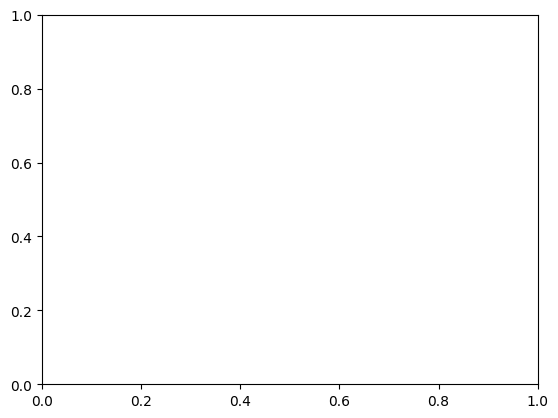

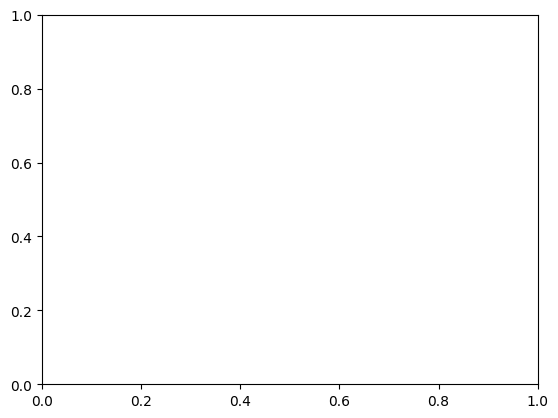

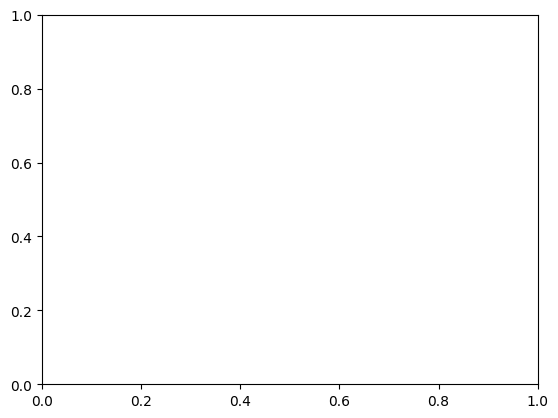

In [16]:
# ESCENARIOS A PROBAR
escenarios = {
    "invierno": {"tmax": 13, "tmin": 3, "prob_lluvia": 30, "UV": 2},
    "verano": {"tmax": 28, "tmin": 16, "prob_lluvia": 5, "UV": 4},
    "anómalo": {"tmax": 40, "tmin": 25, "prob_lluvia": 0, "UV": 11},
}

sistema_ctrl = ctrl.ControlSystem(rules)
sistema = ctrl.ControlSystemSimulation(sistema_ctrl)

# BUCLE PARA GENERAR SALIDAS Y GUARDAR GRÁFICAS
for nombre, datos in escenarios.items():
    sistema.input['tmax'] = datos['tmax']
    sistema.input['tmin'] = datos['tmin']
    sistema.input['prob_lluvia'] = datos['prob_lluvia']
    sistema.input['UV'] = datos['UV']
    sistema.compute()
    
    print(f"Escenario: {nombre.upper()} → Recomendación: {sistema.output['recom_exterior']:.3f}")
    
    plt.subplots()
    recom_exterior.view(sim=sistema)
    plt.ylabel("Grado de pertenencia")
    plt.title(f"Escenario: {nombre}")
    plt.savefig(f"recom_exterior_{nombre}.png")
    plt.close()